# ATTENDANCE AND STADIUM ANALYSIS

In [2]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting the path to access the data
path = r"C:\Users\Mihir\8_CAPSTONE PROJECT\S1_Data_Preprocessing\1_Preprocessing_Data_&_EDA_LEVEL_0\\"
path

'C:\\Users\\Mihir\\8_CAPSTONE PROJECT\\S1_Data_Preprocessing\\1_Preprocessing_Data_&_EDA_LEVEL_0\\\\'

In [4]:
# reading required csv files
appearances = pd.read_csv(path + "appearances_df_no_win.csv")
players = pd.read_csv(path + "players_df_winsorised.csv")
games = pd.read_csv(path + "games_df_winsorised.csv")
game_events = pd.read_csv(path + "game_events_df_no_win.csv")
test = pd.read_csv(path + "test data.csv")

In [5]:
import mysql.connector as sql

host = 'localhost'
user = 'root'
password = '1234'
database = 'football_analysis_eda'

db = sql.connect(host = host, user = user, password = password, 
           database = database)
print("Connection Established- to Database: ", db)

mycursor = db.cursor()
print("Connection to Retrieve data: ", mycursor)

Connection Established- to Database:  <mysql.connector.connection_cext.CMySQLConnection object at 0x0000026DFFD6A690>
Connection to Retrieve data:  CMySQLCursor: (Nothing executed yet)


In [6]:
# Retrieving Data From MySQL Server
## By Creating a View
query = '''SELECT * FROM ATTENDANCE_STADIUM;'''
ATTENDANCE_STADIUM = pd.read_sql_query(query,db)

query2 = '''SELECT * FROM ATTENDANCE_GOALS_CORR;'''
ATTENDANCE_GOALS_CORR = pd.read_sql_query(query2,db)

query3 = '''SELECT * FROM ATTENDANCE_WINS_CORR;'''
ATTENDANCE_WINS_CORR = pd.read_sql_query(query3,db)

# query4 = '''SELECT * FROM STADIUM_OUTCOME_INFLUENCE;'''
# STADIUM_OUTCOME_INFLUENCE = pd.read_sql_query(query4,db)

query5 = '''SELECT * FROM STADIUM_ATTEND_OUTCOME_INFLUENCE;'''
STADIUM_ATTEND_OUTCOME_INFLUENCE = pd.read_sql_query(query5,db)

query6 = '''SELECT * FROM ATTENDANCE_MAX_MIN_ACROSS_SEASONS_COMPETITIONS;'''
ATTENDANCE_MAX_MIN_ACROSS_SEASONS_COMPETITIONS = pd.read_sql_query(query6,db)

query7 = '''SELECT * FROM ATTENDANCE_HOME_CLUBWISE;'''
ATTENDANCE_HOME_CLUBWISE = pd.read_sql_query(query7,db)

query8 = '''SELECT * FROM ATTENDANCE_DAY_MATCH_ROUND_CORR;'''
ATTENDANCE_DAY_MATCH_ROUND_CORR = pd.read_sql_query(query8,db)

query9 = '''SELECT * FROM ATTENDANCE_FAN_ENGAGEMENT_RIVALS;'''
ATTENDANCE_FAN_ENGAGEMENT_RIVALS = pd.read_sql_query(query9,db)

db.close()

# USING KNN CLASSIFICATION
##  Can we classify stadiums based on historical attendance patterns?
### Business Question: Can we predict which stadiums based on historical attendance patterns ?
### Features: stadium, attendance.

Quartile 1:  14550.5
Quartile 3:  42100.0
Median:  26788.0
Mean:  29293.352815177477
IQR:  27549.5
MAX:  81365.0


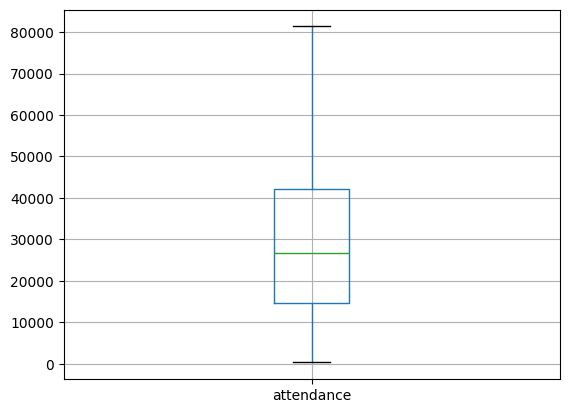

In [187]:
# Check the distribution
q1 = games['attendance'].quantile(0.25)
q3 = games['attendance'].quantile(0.75)
median = games['attendance'].median()
mean = games['attendance'].mean()
iqr = q3 - q1
max = games['attendance'].max()
print("Quartile 1: ", q1)
print("Quartile 3: ",q3)
print("Median: ", median)
print("Mean: ", mean)
print("IQR: ", iqr)
print("MAX: ", max)
games[['attendance']].boxplot()
plt.show()

In [132]:
# Importing required Libraries for preparing Machinge learning
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import datetime

In [168]:
# Making the data ready for machine learning model
# Extracting required columns from games table
knn_df = games[['date', 'season', 'attendance', 'stadium']]
knn_df['date'] = pd.to_datetime(knn_df['date']) # converting to datetime

# Extract day of the week (0=Monday, 6=Sunday)
knn_df['day_of_week'] = knn_df['date'].dt.dayofweek

# Encode the stadiums (dependent features)
le = LabelEncoder()
knn_df['stadium_encoded'] = le.fit_transform(knn_df['stadium'])

# Standardize the independent features
scaler = StandardScaler()
knn_df_scaled = pd.DataFrame(scaler.fit_transform(knn_df[['season', 'attendance', 'day_of_week']]), columns = ['season', 'attendance', 'day_of_week'])
knn_df_scaled

,season,attendance,day_of_week
0,-1.415071,-1.235540,-0.286015
1,-1.415071,-1.254131,0.321720
2,-1.415071,-1.351745,-0.286015
3,-1.415071,-1.116822,0.929455
4,-1.415071,-0.968149,0.929455
...,...,...,...
3263,1.451410,1.189995,-1.501484
3264,0.632415,-1.385156,0.929455
3265,1.041913,-1.212341,0.321720
3266,0.632415,1.723365,0.321720


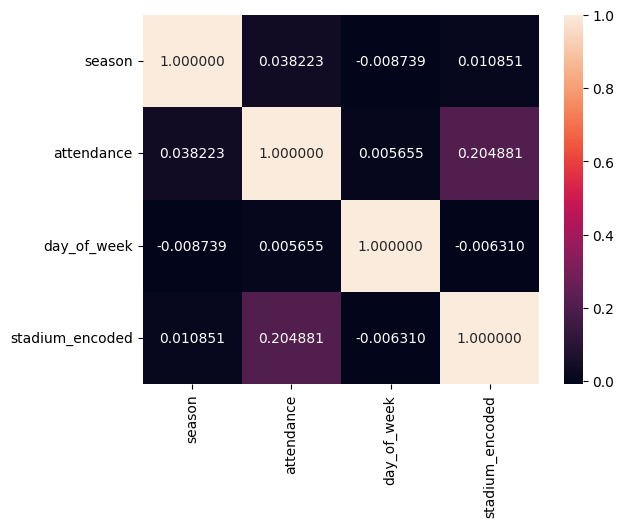

In [170]:
# Checking for Correlation between stadiums and numerical variables
corr = pd.concat((knn_df_scaled, knn_df['stadium_encoded']), axis = 1).corr()
sns.heatmap(corr, annot= True, fmt= '0f')
plt.show()

In [171]:
# Select features: day_of_week, season, and attendance
X = knn_df_scaled[['attendance']]
y = knn_df['stadium_encoded']
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (3268, 1)
y shape:  (3268,)


In [174]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (2287, 1)
X_test shape:  (981, 1)
y_train shape:  (2287,)
y_test shape:  (981,)


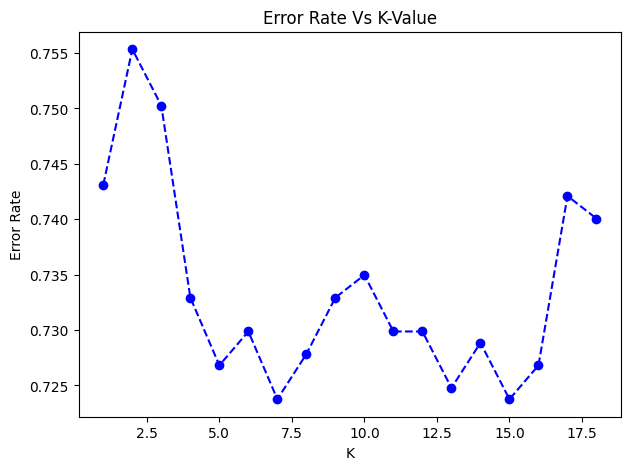

In [176]:
# Finding Optimal k-nearest neighbors with least error rate
from sklearn import neighbors

error_rate = []
n = 20
for i in range(1, n-1):
    clf_food = neighbors.KNeighborsClassifier(n_neighbors = i)
    clf_food.fit(X_train, y_train)
    pred_i = clf_food.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# print(round(np.sqrt(len(X_train))))

# Scatter plot with line chart comparison for lowest error for each k-nearest neighbors
import matplotlib.pyplot as plt
plt.figure(figsize= (7, 5))
plt.plot(range(1, n-1), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o')
plt.title('Error Rate Vs K-Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [219]:
# Taking k-nearest neighbors with lowest error and training the model
knn = KNeighborsClassifier(n_neighbors=15)  
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = knn.predict(X_test)
print("Accuracy on test: ", accuracy_score(y_test, y_pred))

# Check high correct prediction stadiumns
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
display(report_df[report_df['f1-score']>= 0.70])

# Checking the names of high correct prediction stadiums
index_stadiums = report_df[report_df['f1-score']>= 0.70].index
cond = knn_df['stadium_encoded'].astype(str).isin(index_stadiums.astype(str))
display(knn_df.loc[cond][['stadium', 'stadium_encoded']].drop_duplicates())

Accuracy on test:  0.2762487257900102


,precision,recall,f1-score,support
11,0.666667,0.800000,0.727273,15.0
86,0.769231,1.000000,0.869565,10.0
240,0.870968,0.843750,0.857143,32.0
337,0.700000,0.807692,0.750000,26.0


,stadium,stadium_encoded
12,SIGNAL IDUNA PARK,240
19,Veltins-Arena,337
54,Emirates Stadium,86
90,Allianz Arena,11


# SAVING FILES TO EXCEL FOR POWERPOINT PRESENTATIONS

In [60]:
# Define the file path
workbook_path = r'C:\Users\Mihir\8_CAPSTONE PROJECT\excel_files_for_ppt\4_Attendance_Stadium.xlsx'

# Create DataFrame from the player_prob dictionary
try:
    # Proceed with the ExcelWriter if the file exists
    with pd.ExcelWriter(workbook_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        # Save the DataFrame to a new sheet
        
        ATTENDANCE_STADIUM.to_excel(writer, sheet_name="ATTENDANCE_STADIUM", index=False)
        
        ATTENDANCE_GOALS_CORR.to_excel(writer, sheet_name="ATTENDANCE_GOALS_CORR", index=False)
        
        ATTENDANCE_WINS_CORR.to_excel(writer, sheet_name="ATTENDANCE_WINS_CORR", index=False) 

        STADIUM_ATTEND_OUTCOME_INFLUENCE.to_excel(writer, sheet_name="STADIUM_ATTEND_OUTCOME_INFLUEN", index=False)

        # STADIUM_OUTCOME_INFLUENCE.to_excel(writer, sheet_name="STADIUM_OUTCOME_INFLUENCE", index=False)
        
        # STADIUM_ATTENDANCE_INFLUENCE.to_excel(writer, sheet_name="STADIUM_ATTENDANCE_INFLUENCE", index=False)
        
        ATTENDANCE_MAX_MIN_ACROSS_SEASONS_COMPETITIONS.to_excel(writer, sheet_name="ATENDNCE_MAX_MIN_ACR_SEAS_COMP", index=False)
        
        ATTENDANCE_HOME_CLUBWISE.to_excel(writer, sheet_name="ATTENDANCE_HOME_CLUBWISE", index=False)
        
        ATTENDANCE_DAY_MATCH_ROUND_CORR.to_excel(writer, sheet_name="ATTENDANCE_DAY_MATCH_ROUND_CORR", index=False)
        
        ATTENDANCE_FAN_ENGAGEMENT_RIVALS.to_excel(writer, sheet_name="ATTENDANCE_FAN_ENGAGEMENT_RIVALS", index=False)
    
        # TEAM_HOME_PERFORMANCE.to_excel(writer, sheet_name="TEAM_HOME_PERFORMANCE", index=False)
        # TEAM_AWAY_PERFORMANCE.to_excel(writer, sheet_name="TEAM_AWAY_PERFORMANCE", index=False)
        # TEAM_MANAGER_PERFORMANCE.to_excel(writer, sheet_name="TEAM_MANAGER_PERFORMANCE", index=False)
        # TEAM_WIN_RATIO.to_excel(writer, sheet_name="TEAM_WIN_RATIO", index=False)
        # TEAM_POSITION_OUTCOME.to_excel(writer, sheet_name="TEAM_POSITION_OUTCOME", index=False)
        # TEAM_SEASON_PERFORMANCE.to_excel(writer, sheet_name="TEAM_SEASON_PERFORMANCE", index=False)

    print("DataFrames successfully written to Excel.")

except Exception as e:
    print(f"An error occurred while writing to Excel: {e}")

DataFrames successfully written to Excel.
